In [16]:
# Customer Lifetime Value Modeling with PyMC: BG/NBD, Gamma-Gamma
# 📚 Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
from pymc_marketing.clv.utils import rfm_summary
import pytensor as pt

## 🎲 Step 1: Simulate Sample Transaction Data

In [17]:
# 🎲 Step 1: Simulate Sample Transaction Data
np.random.seed(42)

n_customers = 10000
channels = ['Organic', 'Paid', 'Referral']

customer_df = pd.DataFrame({
    'customer_id': [f'C{i}' for i in range(n_customers)],
    'channel': np.random.choice(channels, size=n_customers, p=[0.4, 0.4, 0.2]),
})

customer_df['acquisition_date'] = pd.to_datetime('2023-01-01') + pd.to_timedelta(np.random.randint(0, 30, n_customers), unit='D')

transactions = []
for _, row in customer_df.iterrows():
    cust_id = row['customer_id']
    channel = row['channel']
    start_date = row['acquisition_date']
    num_txn = np.random.poisson(3 if channel == 'Organic' else 2 if channel == 'Referral' else 1.5)
    churn_prob = 0.2 if channel == 'Organic' else 0.35 if channel == 'Referral' else 0.5
    order_value_mean = 60 if channel == 'Organic' else 90 if channel == 'Paid' else 70

    date = start_date
    for _ in range(num_txn):
        if np.random.rand() < churn_prob:
            break
        amount = np.random.gamma(order_value_mean / 10, 10)
        transactions.append([cust_id, date, amount, channel])
        date += pd.to_timedelta(np.random.randint(7, 60), unit='D')
        if date > pd.to_datetime('2023-06-30'):
            break

transactions_df = pd.DataFrame(transactions, columns=['customer_id', 'purchase_date', 'revenue', 'channel'])

transactions_df.to_csv("sample_transactions.csv", index=False)

## 📊 Step 2: Prepare Summary for Hierarchical Modeling

In [18]:
# 📊 Step 2: Prepare Summary for Hierarchical Modeling
transactions_df = pd.read_csv("sample_transactions.csv")
transactions_df['purchase_date'] = pd.to_datetime(transactions_df['purchase_date'])

# Assign cohort index
grouped_channels, cohort_codes = pd.factorize(transactions_df['channel'])
transactions_df['channel_code'] = grouped_channels

summary = rfm_summary(
    transactions_df,
    customer_id_col="customer_id",
    datetime_col="purchase_date",
    monetary_value_col="revenue",
    observation_period_end=pd.to_datetime("2023-07-01")
)

# Remove customers with no repeat purchases or invalid monetary values
summary = summary[(summary['frequency'] > 0) & (summary['monetary_value'] > 0)]

customer_channels = transactions_df.drop_duplicates(subset='customer_id')[['customer_id', 'channel', 'channel_code']]
summary = summary.merge(customer_channels, left_on  = 'customer_id', right_on='customer_id')

## Standardize Inputs
summary['frequency_z'] = (summary['frequency'] - summary['frequency'].min()) / (summary['frequency'].max()-summary['frequency'].min())
summary['recency_z'] = (summary['recency'] - summary['recency'].min()) / (summary['recency'].max()-summary['frequency'].min())
summary['T_z'] = (summary['T'] - summary['T'].min()) / (summary['T'].max()-summary['T'].min())
summary['mv_z'] = (summary['monetary_value'] - summary['monetary_value'].min()) / (summary['monetary_value'].max()-summary['monetary_value'].min())

## 📉 Step 3: Beyesain LTV model
- Model 1 with (Flat Priors, No Hierarchy)
- Model 2 with (Hierarchy)

In [19]:
with pm.Model() as ltv_model:
    # Single-level priors (no cohort-based hierarchy)
    r = pm.Gamma("r", alpha=2, beta=0.5)
    alpha = pm.Gamma("alpha", alpha=2, beta=0.5)
    a = pm.Gamma("a", alpha=2, beta=0.5)
    b = pm.Gamma("b", alpha=2, beta=0.5)

    # Adjusted inputs
    freq = summary['frequency_z'].values + 1
    rec_adj = summary['recency_z'].values + 1
    T_adj = summary['T_z'].values + 1

    # BG/NBD log-likelihood
    ll_bgnbd = (
        pt.tensor.math.gammaln(r + freq)
        - pt.tensor.math.gammaln(r)
        + r * pm.math.log(alpha)
        + freq * pm.math.log(rec_adj + alpha)
        - (r + freq) * pm.math.log(T_adj + alpha)
    )
    pm.Potential("bgnbd_likelihood", ll_bgnbd.sum())

    # Gamma-Gamma model
    mv = summary['mv_z'].values + 1
    p = pm.Gamma("p", alpha=2, beta=0.5, initval=3.0)
    q = pm.Gamma("q", alpha=2, beta=0.5, initval=3.0)
    v = pm.Gamma("v", alpha=2, beta=0.5, initval=10.0)

    # Safeguard for zero division
    eps = 1e-3
    beta_term = pm.math.maximum(v / (freq + q), eps)

    # Gamma likelihood for monetary value
    pm.Gamma("monetary_obs", alpha=p, beta=beta_term, observed=mv)

    # Sampling
    trace = pm.sample(
        draws=1000,
        tune=1000,
        target_accept=0.99,
        random_seed=400,
        return_inferencedata=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [r, alpha, a, b, p, q, v]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 108 seconds.


## 📈 Step 4: Diagnostics

In [20]:
def plot_diagnostics(trace, var_names=["r", "alpha", "p", "q", "v"]):
    print("=== Summary Statistics ===")
    print(az.summary(trace, var_names=var_names, round_to=2)[["mean", "hdi_3%", "hdi_97%", "ess_bulk", "r_hat"]])
    
    print("\n=== Trace Plots ===")
    az.plot_trace(trace, var_names=var_names, figsize=(12, 8))
    plt.show()

    print("\n=== Posterior Distributions ===")
    az.plot_posterior(trace, var_names=var_names, figsize=(12, 6))
    plt.show()

    print("\n=== Energy Plot (Check for divergences) ===")
    az.plot_energy(trace, figsize=(8, 4))
    plt.show()

=== Summary Statistics ===
          mean   hdi_3%  hdi_97%  ess_bulk  r_hat
r      2333.50  2245.36  2428.07   2530.72    1.0
alpha  4635.19  4466.22  4784.35   2688.27    1.0
p        80.55    76.61    84.48   2474.16    1.0
q         5.91     5.40     6.47   2275.22    1.0
v       435.81   393.92   474.72   2027.42    1.0

=== Trace Plots ===


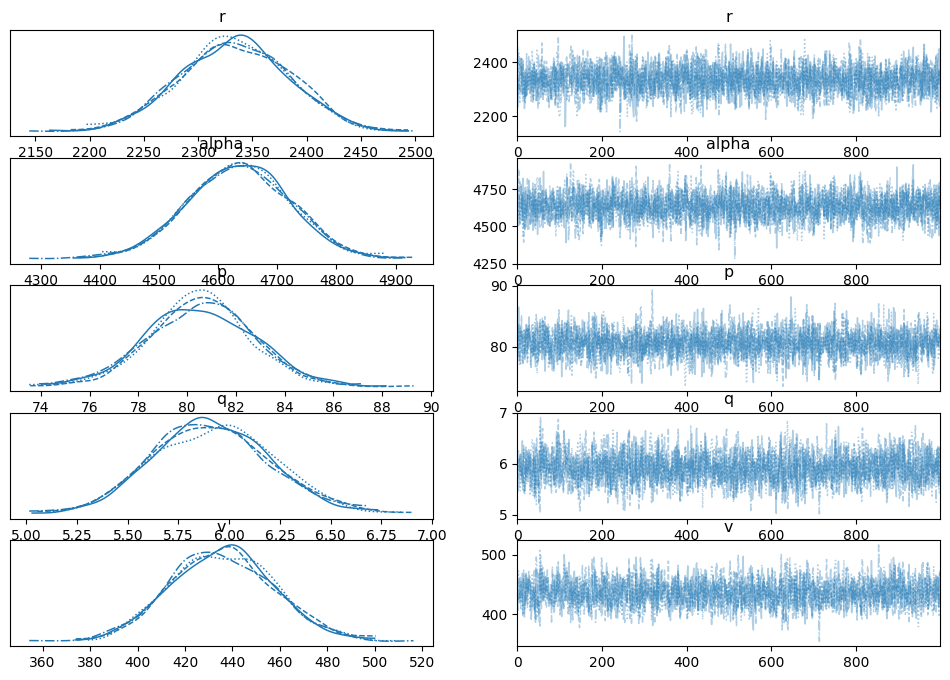


=== Posterior Distributions ===


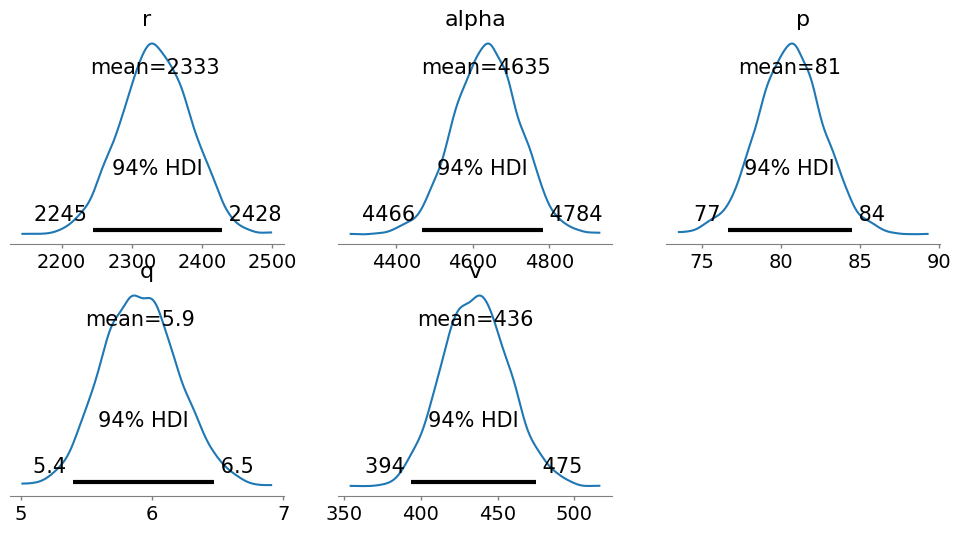


=== Energy Plot (Check for divergences) ===


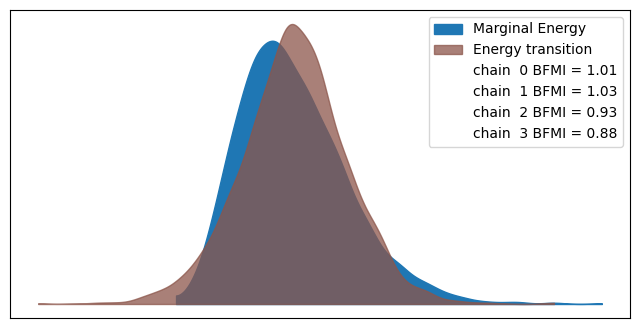

In [21]:
plot_diagnostics(trace, var_names=["r", "alpha", "p", "q", "v"])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


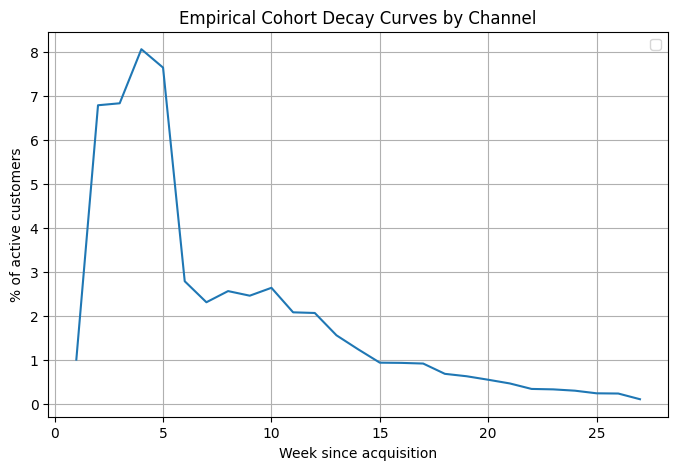

In [22]:
# Empirical Decay Curves
transactions_df['week'] = transactions_df['purchase_date'].dt.to_period('W').apply(lambda r: r.start_time)
cohort_retention = transactions_df.groupby(['week'])['customer_id'].nunique().reset_index()
cohort_retention['week_num'] = cohort_retention['week'].rank().astype(int)

plt.figure(figsize=(8, 5))
plt.plot(cohort_retention['week_num'], cohort_retention['customer_id'] / cohort_retention['customer_id'].iloc[0])

plt.title('Empirical Cohort Decay Curves by Channel')
plt.xlabel('Week since acquisition')
plt.ylabel('% of active customers')
plt.legend()
plt.grid(True)
plt.show()

## 📋 Step 5: Use Case

#### Compute expected LTV from posterior samples

In [23]:
# Function: Compute expected LTV from posterior samples
def compute_expected_ltv(trace, summary_df, future_days=180):
    posterior = trace.posterior

    freq = summary_df["frequency_z"].values + 1
    T = summary_df["T_z"].values + 1
    n_customers = len(freq)

    # Combine samples across chains & draws
    r = posterior["r"].stack(sample=("chain", "draw")).values
    alpha = posterior["alpha"].stack(sample=("chain", "draw")).values
    p = posterior["p"].stack(sample=("chain", "draw")).values
    q = posterior["q"].stack(sample=("chain", "draw")).values
    v = posterior["v"].stack(sample=("chain", "draw")).values

    # If scalar: r.shape = (samples,) → make it (samples, 1)
    if r.ndim == 1:
        r = r[:, None]
        alpha = alpha[:, None]
        p = p[:, None]
        q = q[:, None]
        v = v[:, None]

    # Repeat customer-level data across samples
    freq_matrix = np.tile(freq, (r.shape[0], 1)).T
    T_matrix = np.tile(T, (r.shape[0], 1)).T

    # Expected future purchases
    exp_purchases = (r.T + freq_matrix) / (alpha.T + T_matrix + future_days)

    # Expected monetary value
    exp_value = (p.T * v.T) / ((freq_matrix + q.T) * (p.T - 1))

    ltv = exp_purchases * exp_value
    mean_ltv = np.mean(ltv, axis=1)
    hdi = az.hdi(ltv.T, hdi_prob=0.94)

    return pd.DataFrame({
        "customer_id": summary_df["customer_id"].values,
        "channel": summary_df["channel"].values,
        "expected_ltv": mean_ltv,
        "ltv_hdi_lower": hdi[:, 0],
        "ltv_hdi_upper": hdi[:, 1]
    })

In [24]:
ltv_df = compute_expected_ltv(trace, summary_df=summary, future_days=180)
ltv_df

/var/folders/64/98xdzpq916j7jnwj8vlbxgkm0000gn/T/ipykernel_95948/2240095272.py:36: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = az.hdi(ltv.T, hdi_prob=0.94)


,customer_id,channel,expected_ltv,ltv_hdi_lower,ltv_hdi_upper
0,C0,Organic,30.943728,29.144991,32.710633
1,C1001,Paid,30.941291,29.142716,32.708027
2,C1004,Referral,29.523660,27.831384,31.222244
3,C1015,Referral,30.942177,29.143543,32.708974
4,C1016,Organic,29.518586,27.826613,31.216706
...,...,...,...,...,...
3057,C9986,Organic,30.211621,28.469109,31.936534
3058,C9988,Organic,30.942399,29.143750,32.709211
3059,C9990,Paid,29.517529,27.825619,31.215552
3060,C9991,Organic,29.522180,27.829992,31.220629


### Plot LTV distribution by segment

In [25]:
def plot_ltv_by_segment(ltv_df, segment_col='channel'):
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=ltv_df, x=segment_col, y='expected_ltv')
    plt.title("LTV Distribution by Segment")
    plt.ylabel("Expected LTV")
    plt.xlabel("Segment")
    plt.grid(True)
    plt.show()

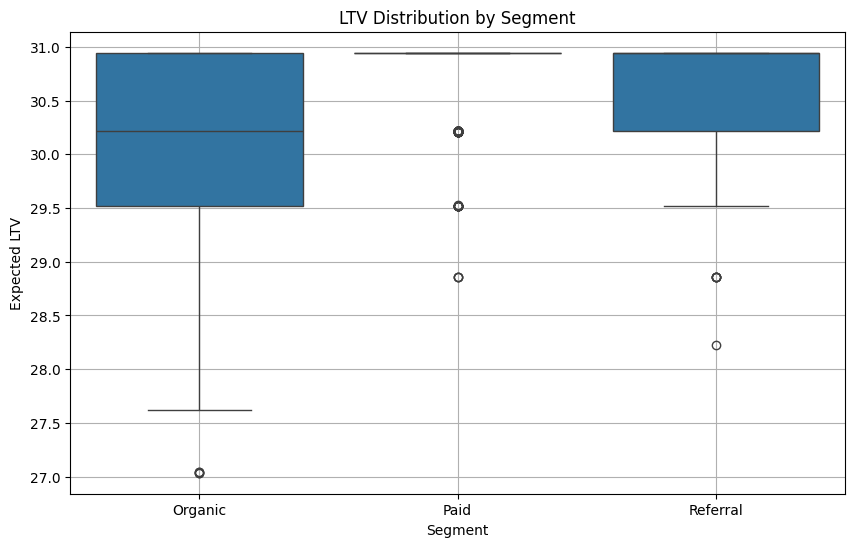

In [26]:
plot_ltv_by_segment(ltv_df, segment_col='channel')

### Customer Segmentation by Predicted LTV
```Prioritizing retention efforts```

```Personalizing email/CRM messaging```

```Defining tiers (Gold/Silver/Bronze)```

In [27]:
# Example segmentation
ltv_df["segment"] = pd.qcut(ltv_df["expected_ltv"], q=4, labels=["Low", "Mid", "High", "Top"])
ltv_df

,customer_id,channel,expected_ltv,ltv_hdi_lower,ltv_hdi_upper,segment
0,C0,Organic,30.943728,29.144991,32.710633,Top
1,C1001,Paid,30.941291,29.142716,32.708027,High
2,C1004,Referral,29.523660,27.831384,31.222244,Low
3,C1015,Referral,30.942177,29.143543,32.708974,High
4,C1016,Organic,29.518586,27.826613,31.216706,Low
...,...,...,...,...,...,...
3057,C9986,Organic,30.211621,28.469109,31.936534,Low
3058,C9988,Organic,30.942399,29.143750,32.709211,Top
3059,C9990,Paid,29.517529,27.825619,31.215552,Low
3060,C9991,Organic,29.522180,27.829992,31.220629,Low


## Future Enhancement: hierarchical_ltv_model
- Challenge: sample size is too small to converge

In [13]:
with pm.Model() as hierarchical_ltv_model:
    n_cohorts = len(cohort_codes)
    cohort_idx = summary['channel_code'].values

    # Hierarchical hyperpriors
    mu_r = pm.Gamma("mu_r", alpha=2, beta=0.5)
    sigma_r = pm.HalfCauchy("sigma_r", beta=1)
    mu_alpha = pm.Gamma("mu_alpha", alpha=2, beta=0.5)
    sigma_alpha = pm.HalfCauchy("sigma_alpha", beta=1)
    mu_a = pm.Gamma("mu_a", alpha=2, beta=0.5)
    sigma_a = pm.HalfCauchy("sigma_a", beta=1)
    mu_b = pm.Gamma("mu_b", alpha=2, beta=0.5)
    sigma_b = pm.HalfCauchy("sigma_b", beta=1)

    r = pm.Gamma("r", alpha=mu_r**2 / sigma_r**2, beta=mu_r / sigma_r**2, shape=n_cohorts)
    alpha = pm.Gamma("alpha", alpha=mu_alpha**2 / sigma_alpha**2, beta=mu_alpha / sigma_alpha**2, shape=n_cohorts)
    a = pm.Gamma("a", alpha=mu_a**2 / sigma_a**2, beta=mu_a / sigma_a**2, shape=n_cohorts)
    b = pm.Gamma("b", alpha=mu_b**2 / sigma_b**2, beta=mu_b / sigma_b**2, shape=n_cohorts)

    # Use adjusted recency and T to prevent log(negative)
    freq = summary['frequency_z'].values+1
    rec_adj = summary['recency_z'].values +1
    T_adj = summary['T_z'].values+1

    ll_bgnbd = (
        pt.tensor.math.gammaln(r[cohort_idx] + freq)
        - pt.tensor.math.gammaln(r[cohort_idx])
        + r[cohort_idx] * pm.math.log(alpha[cohort_idx])
        + freq * pm.math.log(rec_adj + alpha[cohort_idx])
        - (r[cohort_idx] + freq) * pm.math.log(T_adj + alpha[cohort_idx])
    )
    pm.Potential("bgnbd_likelihood", ll_bgnbd.sum())

    # Gamma-Gamma model
    mv = summary['mv_z'].values+1
    p = pm.Gamma("p", alpha=2, beta=0.5, initval=3.0)
    q = pm.Gamma("q", alpha=2, beta=0.5, initval=3.0)
    v = pm.Gamma("v", alpha=2, beta=0.5, initval=10.0)

    #Stabilize Gamma-Gamma Likelihood
    eps = 1e-3
    beta_term = pm.math.maximum(v / (freq + q), eps)

    pm.Gamma("monetary_obs", alpha=p, beta=beta_term, observed=mv)

    # trace = pm.sample(
    #     1000, tune=1000, target_accept=0.99,
    #     # max_treedepth=15, 
    #     random_seed=400,
    #     return_inferencedata=True
    # )